In [18]:
# import ogr, osr
# import gdal
import numpy as np
import matplotlib.pyplot as plt
import fiona, shapely, rasterio
from shapely.geometry import Polygon
from shapely.wkt import dumps, loads
from shapely.geometry import asShape, mapping
from rasterio import features
%matplotlib inline

In [2]:
# daShapefile = "SDM324649_full/ll_gda94/sde_shape/whole/VIC/CATCHMENTS/layer/landuse_2014.shp"

# driver = ogr.GetDriverByName('ESRI Shapefile')

# dataSource = driver.Open(daShapefile, 0) # 0 means read-only. 1 means writeable.

# # Check to see if shapefile is found.
# if dataSource is None:
#     print('Could not open %s' % (daShapefile))
# else:
#     print('Opened %s' % (daShapefile))
#     layer = dataSource.GetLayer()
#     featureCount = layer.GetFeatureCount()
#     print("Number of features: %d" % (featureCount))

In [3]:
file = fiona.open("SDM324649_full/ll_gda94/sde_shape/whole/VIC/CATCHMENTS/layer/landuse_2014.shp")

In [61]:
area_filter = "POLYGON ((142.79501249253747 -37.62573016158374, 142.79363481285884 -37.832739875957245,\
                        143.06774894788782 -37.83260406398416, 143.0691229156846 -37.62518532754736,\
                        142.79501249253747 -37.62573016158374))"
filter_poly = loads(area_filter)
filtered = list(file.values(bbox=filter_poly.bounds))
len(filtered)

1748

In [62]:
for feature in filtered:
    geom = asShape(feature['geometry'])
    buffered = geom.buffer(-0.001)
#     print(buffered)
    if buffered.is_empty:
        filtered.remove(feature)
    else:
        feature['geometry'] = mapping(buffered)

In [49]:
# # select shapes in the area of interest
# # area_filter = "POLYGON ((143.32317350376297 -37.496296386368165, 143.32180000642074 -37.70330610816869,\
# #                         143.59543478539388 -37.70317028876007, 143.5968081449812 -37.49575155973978,\
# #                         143.32317350376297 -37.496296386368165))"
# area_filter = "POLYGON ((142.79501249253747 -37.62573016158374, 142.79363481285884 -37.832739875957245,\
#                         143.06774894788782 -37.83260406398416, 143.0691229156846 -37.62518532754736,\
#                         142.79501249253747 -37.62573016158374))"
# filter_poly = ogr.CreateGeometryFromWkt(area_filter)

# layer.SetSpatialFilter(filter_poly)
# layer.GetFeatureCount()

In [50]:
# layerDefinition = layer.GetLayerDefn()
# [layerDefinition.GetFieldDefn(i).GetName() for i in range(layerDefinition.GetFieldCount())]

In [51]:
# unique_classes = np.unique([feature.items()['LC_DESC_14'] for feature in layer])

In [63]:
unique_classes = np.unique([feature['properties']['LC_DESC_14'] for feature in filtered])

In [64]:
print(unique_classes)

['Brassicas' 'Cereals' 'Legumes' 'Pasture and grassland' 'Unknown' 'Water']


In [65]:
unique_classes_dict = {i + 1: unique_classes[i] for i in range(len(unique_classes))}
unique_classes_dict[0] = 'No data'
unique_classes_dict

{0: 'No data',
 1: 'Brassicas',
 2: 'Cereals',
 3: 'Legumes',
 4: 'Pasture and grassland',
 5: 'Unknown',
 6: 'Water'}

In [66]:
# for i, cls in unique_classes_dict.items():
#     layer.SetAttributeFilter("LC_DESC_14 = '%s'" % cls)
#     print("%s: %d" % (cls, layer.GetFeatureCount()))
# layer.SetAttributeFilter(None)

In [67]:
# # draw regions class by class
# NoData_value = 0
# layer.SetAttributeFilter(None)
# x_min, x_max, y_min, y_max = filter_poly.GetEnvelope()
# x_res = 1022
# y_res = 973
# pixel_size = (x_max - x_min) / x_res

# target_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, gdal.GDT_Byte)
# target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
# # target_ds.SetGeoTransform((x_max, pixel_size, 0, y_min, 0, -pixel_size))
# band = target_ds.GetRasterBand(1)
# band.SetNoDataValue(NoData_value)
# empty_array = np.ones((y_res, x_res)) * NoData_value
# band.WriteArray(empty_array)

# # Rasterize

# # layer.SetAttributeFilter("LC_DESC_14 = '%s'" % unique_classes_dict[6])
# # gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[1])

# for i, cls in unique_classes_dict.items():
#     if i != 0:
#         layer.SetAttributeFilter("LC_DESC_14 = '%s'" % cls)
#         gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[i])

# layer.SetAttributeFilter(None)

In [68]:
unique_classes_inv = {v:k for k,v in unique_classes_dict.items()}
shapes = ((feature['geometry'], unique_classes_inv[feature['properties']['LC_DESC_14']]) for feature in filtered)

In [69]:
x_min, y_min, x_max, y_max = filter_poly.bounds
x_res = 1022
y_res = 973
pixel_size = (x_max - x_min) / x_res
image = features.rasterize(
            ((g, v) for g, v in shapes),
            out_shape=(973, 1022),
            transform=[x_min, pixel_size, 0, y_max, 0, -pixel_size])

/home/mithrillion/anaconda3/lib/python3.5/site-packages/rasterio/features.py:303: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


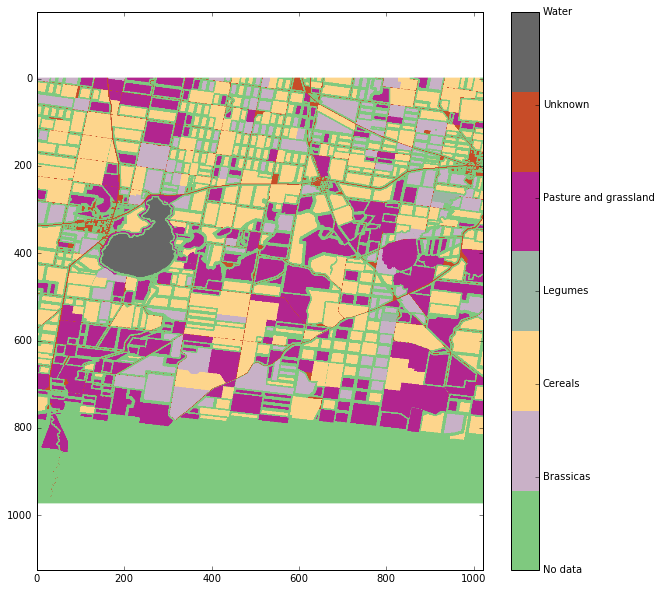

In [70]:
# array = band.ReadAsArray()
plt.figure(figsize=(10, 10))
plt.axis('equal')
im = plt.imshow(image, cmap=plt.cm.get_cmap('Accent', len(unique_classes_dict)))
plt.colorbar(ticks=[0,1,2,3,4,5,6], format=plt.FuncFormatter(lambda val, loc: unique_classes_dict[val]))
plt.show()